In [1]:
import numpy as np 
from BFEE2.postTreatment import postTreatment
import math
import plumed
from BFEE2.commonTools.ploter import mergePMF, writePMF
import matplotlib.pyplot as plt
from jinja2 import Template

In [2]:

def readPMF(filePath):
    """read a 1D PMF file

    Args:
        filePath (str): the path of the PMF file

    Returns:
        np.array (float, 2*N): ((x0,x1,x2, ...), (y0, y1, y2, ...))
    """

    data = np.loadtxt(filePath)
    x = data[:, 0]
    y = data[:, 1]

    return np.array((x, y))

def geometricRestraintContribution(pmf, forceConstant, beta, rmsd=False, unbound=False):
    """calculate the contribution of RMSD and angle restraints

    Args:
        pmf (np.array, float, 2*N): ((x0,x1,x2, ...), (y0, y1, y2, ...))
        forceConstant (float): the force constant of the restraint
        rmsd (bool): whether the contribution of RMSD is being calculated. Defaults to False.
        unbound (bool, optional): whether unbound-state contribution is being calculated. Defaults to False.

    Returns:
        float: contribution of the geometric restraint
    """

    if rmsd:
        # for RMSD, the restraintCenter is zero
        restraintCenter = 0
    else:
        # the minimum of pmf
        restraintCenter = pmf[0][np.argmin(pmf[1])]

    # integration
    numerator = 0
    denominator = 0
    for x, y in zip(pmf[0], pmf[1]):
        numerator += math.exp(-beta * y)
        denominator += math.exp((-beta) * (y + 0.5 * forceConstant * ((x - restraintCenter)**2)))
        
    contribution = math.log(numerator / denominator) / beta

    if unbound:
        return contribution
    else:
        return -contribution

In [3]:
def limitrange(pmf, lower=0, upper=1.75):
    temp_pmf = []
    for x, y in zip(pmf[0], pmf[1]):
        if  lower <= x and x <=upper:
            temp_pmf.append([x, y])
    return np.array(temp_pmf).T

In [4]:

TEMPERATURE = 300 # k
BOLTZMANN = 0.0019872041 # kacl/mol 
beta =  1 / (BOLTZMANN * TEMPERATURE)

In [5]:
# RMSDBOUND NAMD 
forceConstant = 0.1 # kcal/mol A2
pmf_path =  '../../../BFEE2_NAMD_2wi3/BFEE_NAMD/004_EulerPsi/output/abf_1.abf1.czar.pmf'
pmf_namd = readPMF(pmf_path)
#print(pmf.shape)
# pmf2 = limitrange(pmf, 0, 1.75)
# print(pmf2.shape)
dG = geometricRestraintContribution(pmf_namd, forceConstant, beta, rmsd=False, unbound=False)
print(f'dG = {dG:.3f} kcal/mol')

dG = -0.462 kcal/mol


In [6]:
data = plumed.read_as_pandas("../../openmm_plumed/004_EulerPsi/fes.dat")
pmf_plumed = np.array([data["eulerPsi"], data["file.free"]/4.184])
print(pmf_plumed.shape)
#pmf2_op = limitrange(pmf_op, 0, 1.75)
#print(pmf2_op.shape)
dG = geometricRestraintContribution(pmf_plumed, forceConstant, beta, rmsd=False, unbound=False)
print(f'dG = {dG:.3f} kcal/mol')

(2, 191)
dG = -0.587 kcal/mol


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/ndonyapour/tools_drivers/plumed2-2.8.1/src/lib/libplumedKernel.so" +++


In [7]:
data = plumed.read_as_pandas("../004_EulerPsi/fes.dat")
pmf_op = np.array([data["eulerPsi"], data["file.free"]/4.184])
dG = geometricRestraintContribution(pmf_op, forceConstant, beta, rmsd=False, unbound=False)
print(f'dG = {dG:.3f} kcal/mol')

dG = -0.562 kcal/mol


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/ndonyapour/tools_drivers/plumed2-2.8.1/src/lib/libplumedKernel.so" +++


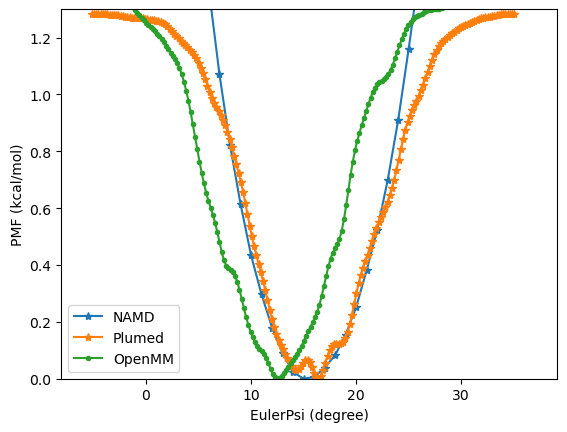

In [8]:
plt.plot(*pmf_namd, "*-", label="NAMD")
plt.plot(*pmf_plumed, "*-", label="Plumed")
plt.plot(*pmf_op, ".-", label="OpenMM")
plt.legend(loc="best")
plt.ylabel("PMF (kcal/mol)")
plt.xlabel("EulerPsi (degree)")
plt.ylim([0, 1.3])
# plt.xlim([-15, 15])
plt.savefig("figures/eulerPsi_NAMD_Plumed_OpenMM_pmf.png")